In [124]:
import os,sys

import ufl
import dolfin as dl

sys.path.append(os.environ.get('HIPPYLIB_PATH', "../../"))
import hippylib as hp
sys.path.append(os.environ.get('HIPPYFLOW_PATH'))
import hippyflow as hf

import torch

import gempy as gp
import gempy_engine
import gempy_viewer as gpv
from gempy_engine.core.backend_tensor import BackendTensor
from gempy_probability.plot_posterior import default_red, default_blue, PlotPosterior

from helpers import *
from generate_samples import *

## Setup gempy model

In [125]:
geo_model_test = create_initial_gempy_model_3_layer(refinement=7, save=True)


Setting Backend To: AvailableBackends.numpy


/home/jt925938/anaconda3/envs/gempy_dino/lib/python3.10/site-packages/gempy/core/data/geo_model.py:164: UserWarning: You are using refinement and passing a regular grid. The resolution of the regular grid will be overwritten
  warnings.warn(


## Setup the problem

In [126]:
nx = 15; ny = 15
mesh = dl.RectangleMesh(dl.Point(0.0, 0.0), dl.Point(1.0, 1.0), nx, ny)
Vh_STATE = dl.FunctionSpace(mesh, "CG", 2)
Vh_PARAMETER = dl.FunctionSpace(mesh, "CG", 1)
Vh = [Vh_STATE, Vh_PARAMETER, Vh_STATE]

d2v = dl.dof_to_vertex_map(Vh[hp.PARAMETER])
v2d = dl.vertex_to_dof_map(Vh[hp.PARAMETER])


def u_boundary(x, on_boundary):
    return on_boundary and ( x[1] < dl.DOLFIN_EPS or x[1] > 1.0 - dl.DOLFIN_EPS)

u_bdr = dl.Expression("x[1]", degree=1)
u_bdr0 = dl.Constant(0.0)
bc = dl.DirichletBC(Vh[hp.STATE], u_bdr, u_boundary)
bc0 = dl.DirichletBC(Vh[hp.STATE], u_bdr0, u_boundary)

f = dl.Constant(0.0)

def pde_varf(u,m,p):
    return m*ufl.inner(ufl.grad(u), ufl.grad(p))*ufl.dx - f*p*ufl.dx

pde = hp.PDEVariationalProblem(Vh, pde_varf, bc, bc0, is_fwd_linear=True)


# GEMPY VERTEX MAPPING
loaded_array = mesh.coordinates()

if loaded_array.shape[1]==2:
    xyz_coord = np.insert(loaded_array, 1, 0, axis=1)
elif loaded_array.shape[1]==3:
    xyz_coord = loaded_array
gp.set_custom_grid(geo_model_test.grid, xyz_coord=xyz_coord)
geo_model_test.interpolation_options.mesh_extraction = False

Active grids: ['custom']


## Generate samples of the state.


NOTE I AM USING A SIMPLE MPI RANK PROCESS SO THE ARRAY OPERATION `.get_local()` MAY NEED TO BE MODIFIED IN AN MPI PARALLEL CONTEXT. HOWEVER FOR PROBLEMS THAT ARE THIS SMALL THERE IS NO JUSTIFICATION FOR MPI PARALLELISM FOR THE MESH

In [ ]:
sp_coords_copy_test = geo_model_test.interpolation_input.surface_points.sp_coords.copy()
###############################################################################
# Make a list of gempy parameter which would be treated as a random variable
###############################################################################
dtype =torch.float64
test_list=[]
test_list.append({"update":"interface_data","id":torch.tensor([1]), "direction":"Z", "prior_distribution":"normal","normal":{"mean":torch.tensor(sp_coords_copy_test[1,2],dtype=dtype), "std":torch.tensor(0.06,dtype=dtype)}})
test_list.append({"update":"interface_data","id":torch.tensor([4]), "direction":"Z", "prior_distribution":"normal","normal":{"mean":torch.tensor(sp_coords_copy_test[4,2],dtype=dtype), "std":torch.tensor(0.06,dtype=dtype)}})

num_layers = len(test_list) # length of the list

Gempy = GempyModel(test_list, geo_model_test, num_layers, dtype=torch.float64)

c = Gempy.GenerateInputSamples(number_samples=500)
m_data, dmdc_data = Gempy.GenerateOutputSamples(Inputs_samples=c)

Setting Backend To: AvailableBackends.PYTORCH
Condition number: 3270.8855697435865.
Condition number: 937.8272903875738.
Condition number: 2436.5127694562807.
Condition number: 3302.2335389751343.
Condition number: 949.318390970095.
Condition number: 1544.511691510481.
Condition number: 1832.502779225806.
Condition number: 2814.176813534337.
Condition number: 1661.4269154415326.
Condition number: 3073.036468041168.
Condition number: 2411.0580625796224.
Condition number: 1627.7737791580153.
Condition number: 3795.6690311011444.
Condition number: 3749.7420342733126.
Condition number: 3737.615611360862.
Condition number: 2890.853976067783.
Condition number: 2198.617452676922.
Condition number: 2489.7020958054213.
Condition number: 1726.7258723242321.
Condition number: 3075.784857827388.
Condition number: 1006.1861044335019.
Condition number: 3771.9519775906892.
Condition number: 2137.800141704474.
Condition number: 1708.003555378283.
Condition number: 2017.2809246578468.
Condition number:

In [128]:
c.shape, m_data.shape, dmdc_data.shape

((100, 2), (100, 256), (100, 256, 2))

In [129]:
#m_data[8].reshape(11,11)

In [130]:
u_trial = dl.TrialFunction(Vh[hp.STATE])
u_test = dl.TestFunction(Vh[hp.STATE])

M_U = dl.assemble(dl.inner(u_trial,u_test)*dl.dx)

I_U = hf.StateSpaceIdentityOperator(M_U)

observable = hf.LinearStateObservable(pde,M_U)

Jm = hf.ObservableJacobian(observable)

m_trial = dl.TrialFunction(Vh[hp.PARAMETER])
m_test = dl.TestFunction(Vh[hp.PARAMETER])

M_M = dl.assemble(dl.inner(m_trial,m_test)*dl.dx)

In [131]:
nsamples = c.shape[0]

m = dl.Function(Vh[hp.PARAMETER])

u = dl.Function(Vh[hp.STATE])
uadj = dl.Function(Vh[hp.ADJOINT])

dU = u.vector().get_local().shape[0]

dC = c.shape[1]

# once you have modified the means of c->m(c) comment this
#sol = gp.compute_model(geo_model_test)
#m_values = geo_model_test.solutions.octrees_output[0].last_output_center.custom_grid_values
uhat = dl.Function(Vh[hp.STATE])
m_nodes_hat = dl.Function(Vh[hp.PARAMETER])
m_hat = dl.Function(Vh[hp.PARAMETER])
u_data = np.zeros((nsamples,dU))
J_data = np.zeros((nsamples, dU, dC))

plotting = False
for sample_index in range(nsamples):
    # Do something here to modify the coefficients
    # sol = gp.compute_model(geo_model_test)
    #m_values = geo_model_test.solutions.octrees_output[0].last_output_center.custom_grid_values
    
    m_values = m_data[sample_index,:]
    m.vector().set_local(m_values[d2v]) #uncomment this
    # m.vector().set_local(m_values[d2v] +0.1*np.random.randn(m_values.shape[0])) #comment this
    if plotting:
        #plt.axis("off")
        dl.plot(m)
        fig = plt.gcf()
        fig.set_size_inches(1, 1)
        plt.show()
    x = [u.vector(),m.vector(),uadj.vector()]
    pde.solveFwd(x[hp.STATE], x)
    
    Jm.observable.setLinearizationPoint(x)
    
    
    # Get the data
    u_data[sample_index,:] = x[hp.STATE].get_local()
    
    for component in range(dC):
        #mhat.vector().set_local(dmdc[:,i])
        m_nodes_hat.vector().set_local(dmdc_data[sample_index,:,component])
        M_M.mult(m_nodes_hat.vector(), m_hat.vector())
        Jm.mult(m_hat.vector(),uhat.vector())
        J_data[sample_index,:,component] = uhat.vector().get_local()
    
u_data.shape, J_data.shape

((100, 961), (100, 961, 2))

## POD

In [132]:
# u_trial = dl.TrialFunction(Vh[hp.STATE])
# u_test = dl.TestFunction(Vh[hp.STATE])

# M_U = dl.assemble(dl.inner(u_trial,u_test)*dl.dx)

POD = hf.PODProjectorFromData(Vh,M_output = M_U)

mean_shifting = True

# Change this later on to be chosen appropriately.
u_rank = len(u_data)
print(u_rank)
d, phi, Mphi, u_shift  = POD.construct_subspace(u_data, u_rank, shifted=mean_shifting, method='hep', verify=True)

100
Using HEP
Preprocessing took 0.00115 seconds
Eigenvalue solve took 0.00104 seconds
Postprocessing took 0.00525 seconds
Basis Orthogonality error: 0.0003166093216191034
Basis-Projector Orthogonality error: 0.0003166093216191034
Mean reconstruction error: 4.504e-10
Max reconstruction error: 1.545e-09


In [133]:
## Compare reconstructions in POD basis

################################################################################
True state


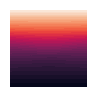

################################################################################
POD projected state


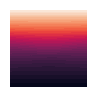

################################################################################
As you can see, this problem is trivial, as only ten modes basically perfectly reconstruct the trivial output function


In [134]:
print(80*'#')
print('True state')
u.vector().set_local(u_data[0])
plt.axis("off")
dl.plot(u)
fig = plt.gcf()
fig.set_size_inches(1, 1)
plt.show()

print(80*'#')
print('POD projected state')
u.vector().set_local(phi@Mphi.T@(u_data[0] - u_shift) + u_shift)
plt.axis("off")
dl.plot(u)
fig = plt.gcf()
fig.set_size_inches(1, 1)
plt.show()

print(80*'#')
print('As you can see, this problem is trivial, as only ten modes basically perfectly reconstruct the trivial output function')

## (Linear) encoders and decoders.

Please consult our papers for a more in-depth discussion. E.g., [section 2.4 in this work](https://arxiv.org/abs/2411.12726)

We can expand a function on an orthonormal basis as

$$ u(x) = \sum_{i=1}^\infty \langle u(x),\phi_i(x)\rangle_\mathcal{U} \phi_i(x)$$

and the truncated representation

$$ u(x) = \sum_{i=1}^r \langle u(x),\phi_i(x)\rangle_\mathcal{U} \phi_i(x)$$

The encoder is the mapping from the data $u(x)$ to its truncated coefficient expansion $\mathcal{E}_r u \in \mathbb{R}^{r}$

$$ \mathcal{E}_r u = \left[\langle u,\phi_i\rangle_\mathcal{U}\right]_{i=1}^r \in \mathbb{R}^{r}$$

The decoder maps this data back to the function space (e.g., the basis expansion operation), given $\alpha \in \mathbb{R}^r$ we have

$$ \mathcal{D}_r \alpha  = \sum_{i=1}^r \alpha_i \phi_i$$

The encoder has the effect of the inner product $\langle \cdot,\cdot\rangle_\mathcal{U}$, e.g., the mass matrix in finite elements, each column of it is $\langle \cdot, \phi\rangle_\mathcal{U}$, so we call it `Mphi` $\in \mathbb{R}^{d_u \times r}$. Likewise we call the decoder `\phi` since its columns are just the basis vectors

### Encoding u data

The mapping to the coefficients of u is $u_r = \mathcal{E}_r u$. In numpy this is `ur_data = Mphi.T@u_data`

### Decoding the u data

We decode with the basis: $\mathcal{D}_r u_r$. In numpy this is `phi@ur_data`

### Encoding and decoding the derivatives.

The derivative of the map is 

$$ Du(c) \in \mathcal{L}(\mathbb{R}^{d_c},\mathcal{U}) $$

that is, the space of linear operators from $\mathbb{R}^{d_c}$ into $\mathcal{U}$. We want to remove the high-dimensionality associated with $\mathcal{U}$

This is done with the encoder operator:

$$\mathcal{E}_r Du(c) \in \mathbb{R}^{r\times d_c}$$

In [135]:
# Encode the u_data

ur = np.einsum('ur,du->dr',Mphi,u_data)

# Encoder the Du_data

dc = 2
Du_data = np.random.randn(nsamples,dU,dc)
Dur_data = np.einsum('ur,duc->drc',Mphi,Du_data)

## Training data

The training data then is inputs (`c_data` \in $\mathbb{R}^{nsamples\times dc}$) and outputs (`ur_data`, `Dur_data`)


## To figure out in the $Du(c)$ calculations

The derivative I believe should have the mass matrix for $\mathcal{M}$ space in it:

$$ Du(c) = D_m(u(m(c)) \frac{dm}{dc} = -\left[\frac{\partial R}{\partial u}\right]^{-1}\frac{\partial R}{\partial m} \frac{dm}{dc}$$

In the other notebook we are evaluating the mapping from $c\mapsto m_\text{node}$, the nodal representation of $m$, but not the function. The mapping to the function requires the mass matrix

The torch gempy code will give you
$$ \frac{dm_\text{node}}{dc}$$

and we need in the end
$$ \frac{dm}{dc} = M_\mathcal{M} \frac{dm_\text{node}}{dc}$$

In [136]:
# Calculating the mass matrix for $\mathcal{M}$


In [137]:
m_trial = dl.TrialFunction(Vh[hp.PARAMETER])
m_test = dl.TestFunction(Vh[hp.PARAMETER])

M_M = dl.assemble(dl.inner(m_trial,m_test)*dl.dx)

## Final form of the pre-reduced Jacobian

$$ Du(c) = -\left[\frac{\partial R}{\partial u}\right]^{-1}\frac{\partial R}{\partial m} M_\mathcal{M}\frac{dm_\text{node}}{dc}$$

Where 

$$ \frac{dm_\text{node}}{dc} \in \mathbb{R}^{d_\text{node}\times dc}$$

is the nodal Jacobian you will get as the output from the gempy torch automatic differntiation

## DOF ORDERING FOR m

You will also need to check the correct degree of freedom mapping for $m$

It will likely be something like the code we had: `m_values[d2v]`

So the output of your torch AD for dm_node/dc will need to have each column reordered using the d2v re-ordering.

When in doubt, plot everything. Do you see that I am constantly plotting to make sure that I am dealing with the right thing? If you get the vertex to dof map wrong you will be able to see it immediately via plotting columns of the Jacobian.

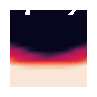

In [138]:
m = dl.Function(Vh[hp.PARAMETER])
m_nodes_hat = dl.Function(Vh[hp.PARAMETER])
m_hat = dl.Function(Vh[hp.PARAMETER])
m.vector().set_local(m_data[0,:][d2v])

plt.axis("off")
dl.plot(m)
fig = plt.gcf()
fig.set_size_inches(1, 1)

################################################################################


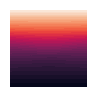

In [139]:
print(80*'#')

u.vector().set_local(u_data[0])
plt.axis("off")
dl.plot(u)
fig = plt.gcf()
fig.set_size_inches(1, 1)
plt.show()

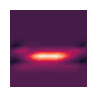

In [140]:
m_nodes_hat.vector().set_local(dmdc_data[0,:,0][d2v])
M_M.mult(m_nodes_hat.vector(), m_hat.vector())
plt.axis("off")
dl.plot(m_hat)
#dl.plot(m_nodes_hat)
fig = plt.gcf()
fig.set_size_inches(1, 1)

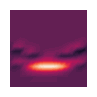

In [141]:
m_nodes_hat.vector().set_local(dmdc_data[0,:,1][d2v])
M_M.mult(m_nodes_hat.vector(), m_hat.vector())
plt.axis("off")
#dl.plot(m_nodes_hat)
dl.plot(m_hat)
fig = plt.gcf()
fig.set_size_inches(1, 1)

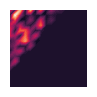

In [142]:
u_hat = dl.Function(Vh[hp.STATE])
u_hat.vector().set_local(J_data[0,:,0][d2v])
plt.axis("off")
dl.plot(u_hat)
fig = plt.gcf()
fig.set_size_inches(1, 1)

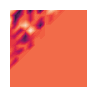

In [143]:
u_hat = dl.Function(Vh[hp.STATE])
u_hat.vector().set_local(J_data[0,:,1][d2v])
plt.axis("off")
dl.plot(u_hat)
fig = plt.gcf()
fig.set_size_inches(1, 1)

In [144]:
Dur_data = np.einsum('ur,duc->drc',Mphi,J_data)
ur.shape, Dur_data.shape

((100, 100), (100, 100, 2))